In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics # for the evaluation
from sklearn.preprocessing import LabelEncoder,MinMaxScaler
import tensorflow as tf
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import math
from keras.models import Sequential
from keras.layers import LSTM, Bidirectional, Dense
import math

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


### data

In [ ]:
log_ddf=pd.read_csv("/content/drive/MyDrive/AI-HPA_Model/data/log_df.csv")
log_ddf.drop([0], inplace=True)
log_ddf.reset_index(inplace=True)
log_ddf.drop(['index'], axis=1, inplace=True)

In [ ]:
log_ddf.isnull().sum()

datetime    0
ip          0
dtype: int64

In [ ]:
log_ddf.min()['ip'], log_ddf.max()['ip']

(1.0, 1982.0)

In [ ]:
# cpu 전체 사용량으로 변환(0.021~41.622)
log_ddf["cpu_usage"]=log_ddf["ip"]*0.021

In [ ]:
log_ddf.min()['cpu_usage'], log_ddf.max()['cpu_usage']

(0.021, 41.622)

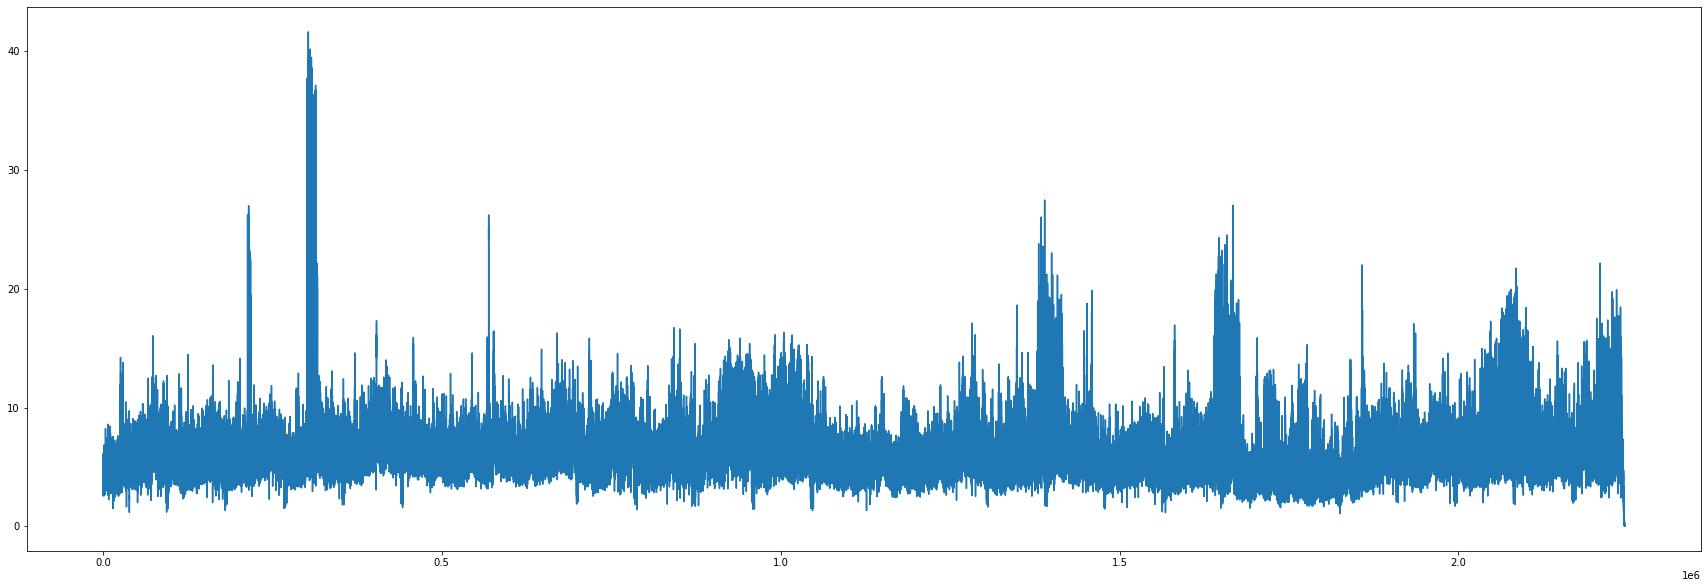

In [ ]:
plt.figure(figsize=(30,10))

plt.plot(log_ddf['cpu_usage'])

plt.show()

In [ ]:
# max_usage에 따른 Pod 개수 산출
max_usage=0.5000 # ms
use_ratio=0.8 # 최대 사용 비율
log_ddf["pods"]=-1

for i in range(len(log_ddf["cpu_usage"])):
  log_ddf["pods"][i]=math.ceil(log_ddf["cpu_usage"][i]/(max_usage*use_ratio))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [ ]:
log_ddf.min()['pods'], log_ddf.max()['pods']

(1, 105)

In [ ]:
log_ddf.to_csv("/content/drive/MyDrive/AI-HPA_Model/data/log_df_pods.csv")

In [ ]:
log_ddf=pd.read_csv("/content/drive/MyDrive/AI-HPA_Model/data/log_df_pods.csv").drop(["Unnamed: 0"], axis=1)

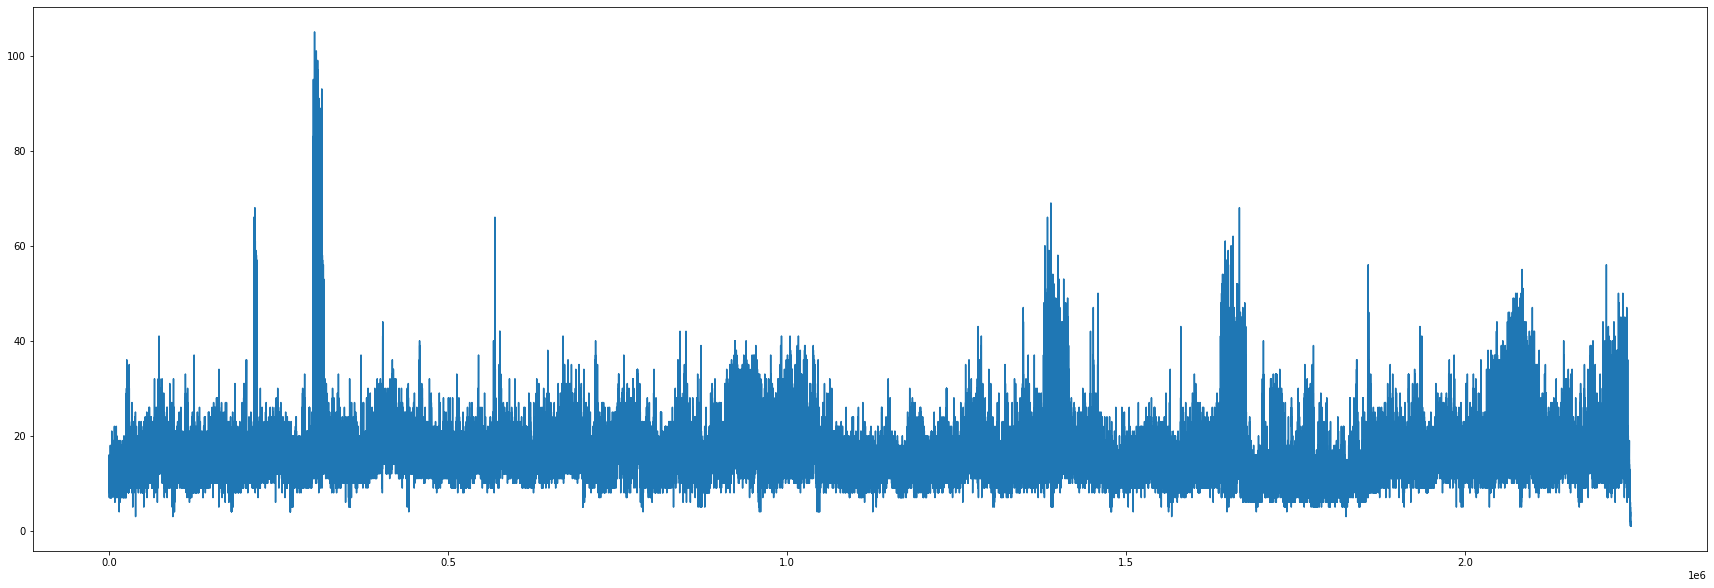

In [ ]:
plt.figure(figsize=(30,10))

plt.plot(log_ddf['pods'])

plt.show()

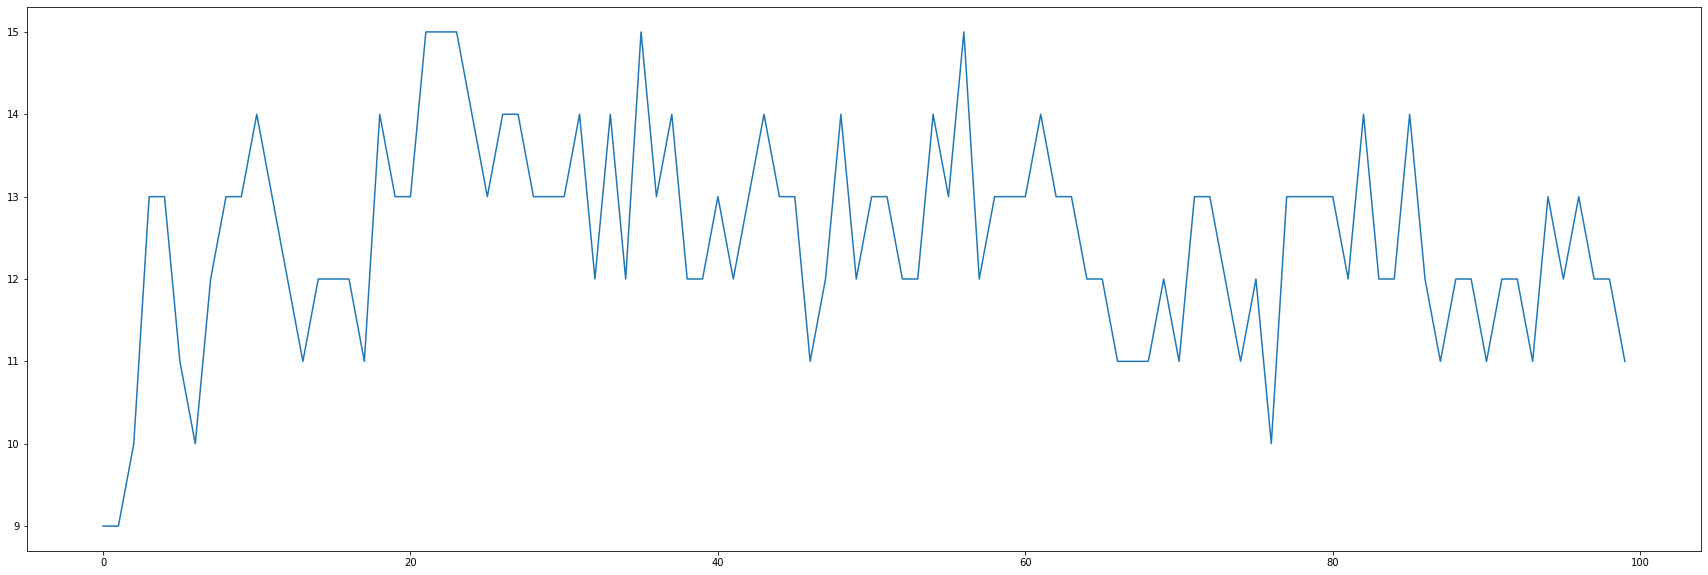

In [ ]:
plt.figure(figsize=(30,10))

plt.plot(log_ddf['pods'][:100])

plt.show()

In [ ]:
# univariate bidirectional lstm
from numpy import array
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Bidirectional

from sklearn.metrics import mean_squared_error

### split a univariate sequence

In [ ]:
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

In [ ]:
def shape_seq(raw_seq, n_steps, n_features):
    # raw_seq=list(log_ddf_null['ip'])[:60480]

    # choose a number of time steps
    # n_steps = 30
    
    # split into samples
    X, y = split_sequence(raw_seq, n_steps)
    print('split sequence: ', X.shape, y.shape)

    # reshape from [samples, timesteps] into [samples, timesteps, features]
    # n_features = 1
    X = X.reshape((X.shape[0], X.shape[1], n_features))

    
    print('reshape: ', X.shape, y.shape)
    
    return X, y

### input

In [ ]:
log_ddf['datetime']=pd.to_datetime(log_ddf['datetime'])
log_ddf=log_ddf.set_index(log_ddf['datetime'])
log_df_index=log_ddf.drop(['datetime'], axis=1)

In [ ]:
def set_model(train_data, n_steps, n_features, epochs, verbose, val_data):
    # # define model
    # model = Sequential()

    # # 다음 레이어에도 순환신경망이 나오는 경우, return_sequences = True로 설정하면 에러가 나지 않음
    # # Dense로 연결하는 경우 : return_sequences = False
    # model.add(Bidirectional(LSTM(50), input_shape=(n_steps, n_features)))
    # model.add(Dense(1))
    # model.compile(optimizer='adam', loss='mse')
    # # fit model
    # hist=model.fit(X, y, epochs=epochs, verbose=verbose)
    with tf.device('/device:GPU:0'):
      model = tf.keras.models.Sequential([
          Bidirectional(LSTM(200, return_sequences=True), input_shape=(n_steps, n_features)),
          Dense(128, activation='tanh'),
          Bidirectional(tf.keras.layers.LSTM(200)),
          tf.keras.layers.Dropout(0.4),
          Dense(128, activation='tanh'),
          Dense(128, activation='tanh'),
          tf.keras.layers.Dropout(0.4),
          Dense(units=n_steps),
      ])
      model.compile(optimizer='adam', loss=tf.keras.metrics.mean_squared_error, metrics=[tf.keras.metrics.MeanSquaredError(name='mse')])#tf.keras.optimizers.RMSprop(learning_rate=0.007), loss=tf.keras.metrics.mean_squared_error, metrics=[tf.keras.metrics.MeanSquaredError(name='mse')]
      model.summary() 
    
      model_path = 'model.h5'
      early_stopings = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=20, verbose=1, mode='min')
      checkpoint =  tf.keras.callbacks.ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, mode='min', verbose=0)
      callbacks=[early_stopings,checkpoint]
      hist=model.fit(train_data, epochs=epochs,steps_per_epoch=100,callbacks=callbacks, verbose=verbose,validation_data=val_data, validation_steps=20)
      return model

In [ ]:
def get_mse(test_data, model, n_steps, n_features):
    # demonstrate prediction
    data_size=len(test_data)
    
    predict_list=[]

    for i in range(data_size-n_steps):
        x_input = array(test_data[i:i+n_steps])
        x_input = x_input.reshape((1, n_steps, n_features))
        yhat = model.predict(x_input, verbose=0)
        predict_list.append([i+n_steps, yhat[0][0]])
    
    return mean_squared_error(test_data[n_steps:], pd.DataFrame(predict_list)[1])

In [ ]:
def process(data, cols, time_sample, n_steps, n_features, epochs, size, verbose,batch_size = 128, buffer_size = 150):
    mse_df=pd.DataFrame(columns=list(cols), index=list(time_sample))
    for t in time_sample:
        for i in range(2):
            if i==0:
                df=pd.DataFrame(data.resample(t).min());
            elif i==1:
                df=pd.DataFrame(data.resample(t).max());  
            # elif i==2:
            #     df=pd.DataFrame(data.resample(t).mean());

            X, y=shape_seq(array(list(df['ip'])[:size]), n_steps, n_features)
            train_data = tf.data.Dataset.from_tensor_slices((X, y))
            train_data = train_data.cache().shuffle(buffer_size).batch(batch_size).repeat()
            
            X_val, y_val=shape_seq(array(list(df['ip'])[size:10000]), n_steps, n_features)
            val_data = tf.data.Dataset.from_tensor_slices((X_val, y_val))
            val_data = val_data.batch(batch_size).repeat()  
                     
            model=set_model(train_data, n_steps, n_features, epochs, verbose, val_data)
            mse=get_mse(array(list(df['ip'])[size:10000]), model, n_steps, n_features)
            mse_df[cols[i]][t]=mse
            print("MSE ['%s']['%s'] : %f\n--------------------------------------\n"%(cols[i], t, mse))
    min_val=100000
    min_time=''
    min_col=''
    for i in range(len(cols)):
        for j in range(len(time_sample)):
            if mse_df[cols[i]][time_sample[j]]<min_val:
                min_val=mse_df[cols[i]][time_sample[j]]
                min_time=time_sample[j]
                min_col=cols[i]
    print(mse_df)
    print("\n--------------------------------------\nMin MSE: %f, time: %s, col: %s"%(min_val, min_time, min_col))

In [ ]:
data=log_df_index['ip']
cols=["min","mean"] #, "median", "first", "last"]
time_sample=['0.2T','0.5T','1T'] #, '2T','3T','4T','5T']
n_steps=10
n_features=1
epochs=200
size=7000
verbose=1
mse_df=process(data, cols, time_sample, n_steps, n_features, epochs, size, verbose)

split sequence:  (6990, 10) (6990,)
reshape:  (6990, 10, 1) (6990,)
split sequence:  (2990, 10) (2990,)
reshape:  (2990, 10, 1) (2990,)
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_20 (Bidirecti  (None, 10, 400)          323200    
 onal)                                                           
                                                                 
 dense_66 (Dense)            (None, 10, 128)           51328     
                                                                 
 bidirectional_21 (Bidirecti  (None, 400)              526400    
 onal)                                                           
                                                                 
 dropout_27 (Dropout)        (None, 400)               0         
                                                                 
 dense_67 (Dense)            (None, 128)         

## Best Model

Min MSE: 0.000560, time: 1T, col: min

Min MSE: 0.014447, time: 0.5T, col: mean

Min MSE: 3.724641, time: 0.5T, col: min

Min MSE: 1514.238678, time: 0.5T, col: min

In [ ]:
data=log_df_index['ip']
cols="min"
time_sample='0.5T'
n_steps=10
n_features=1
epochs=200
size=7000
verbose=1
batch_size = 128
buffer_size = 150

df=pd.DataFrame(data.resample(time_sample).mean());


X, y=shape_seq(array(list(df['ip'])[:size]), n_steps, n_features)
train_data = tf.data.Dataset.from_tensor_slices((X, y))
train_data = train_data.cache().shuffle(buffer_size).batch(batch_size).repeat()

X_val, y_val=shape_seq(array(list(df['ip'])[size:10000]), n_steps, n_features)
val_data = tf.data.Dataset.from_tensor_slices((X_val, y_val))
val_data = val_data.batch(batch_size).repeat()  
           
with tf.device('/device:GPU:0'):
  model = tf.keras.models.Sequential([
      Bidirectional(LSTM(200, return_sequences=True), input_shape=(n_steps, n_features)),
      Dense(128, activation='tanh'),
      Bidirectional(tf.keras.layers.LSTM(200)),
      tf.keras.layers.Dropout(0.4),
      Dense(128, activation='tanh'),
      Dense(128, activation='tanh'),
      tf.keras.layers.Dropout(0.4),
      Dense(units=n_steps),
  ])
  model.compile(optimizer='adam', loss=tf.keras.metrics.mean_squared_error, metrics=[tf.keras.metrics.MeanSquaredError(name='mse')])#tf.keras.optimizers.RMSprop(learning_rate=0.007), loss=tf.keras.metrics.mean_squared_error, metrics=[tf.keras.metrics.MeanSquaredError(name='mse')]
  model.summary() 

  model_path = 'model.h5'
  early_stopings = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=20, verbose=1, mode='min')
  checkpoint =  tf.keras.callbacks.ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, mode='min', verbose=0)
  callbacks=[early_stopings,checkpoint]
  hist=model.fit(train_data, epochs=epochs,steps_per_epoch=100,callbacks=callbacks, verbose=verbose,validation_data=val_data, validation_steps=20)


split sequence:  (6990, 10) (6990,)
reshape:  (6990, 10, 1) (6990,)
split sequence:  (2990, 10) (2990,)
reshape:  (2990, 10, 1) (2990,)
Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_32 (Bidirecti  (None, 10, 400)          323200    
 onal)                                                           
                                                                 
 dense_90 (Dense)            (None, 10, 128)           51328     
                                                                 
 bidirectional_33 (Bidirecti  (None, 400)              526400    
 onal)                                                           
                                                                 
 dropout_39 (Dropout)        (None, 400)               0         
                                                                 
 dense_91 (Dense)            (None, 128)         

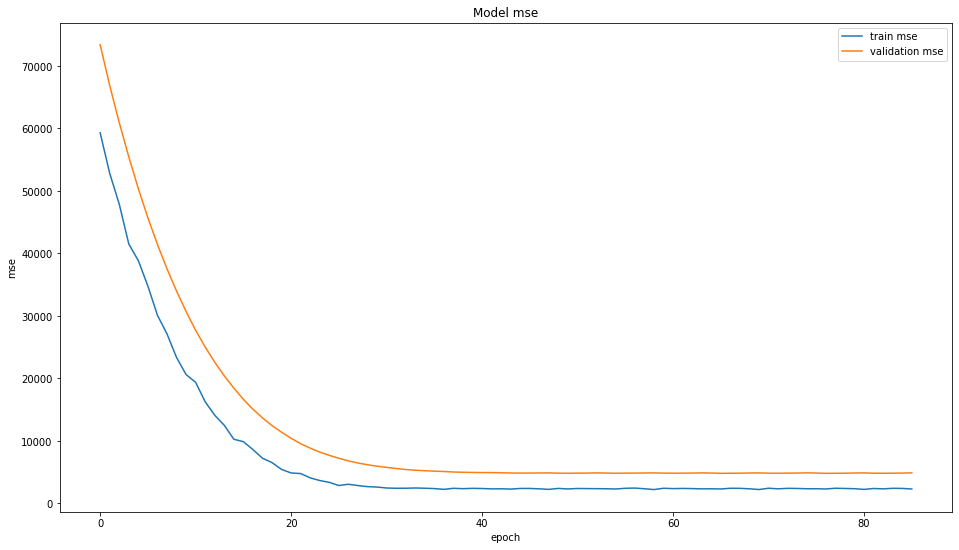

In [ ]:
plt.figure(figsize=(16,9))
plt.plot(hist.history['mse'])
plt.plot(hist.history['val_mse'])
plt.title('Model mse')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.legend(['train mse', 'validation mse'])
plt.show()

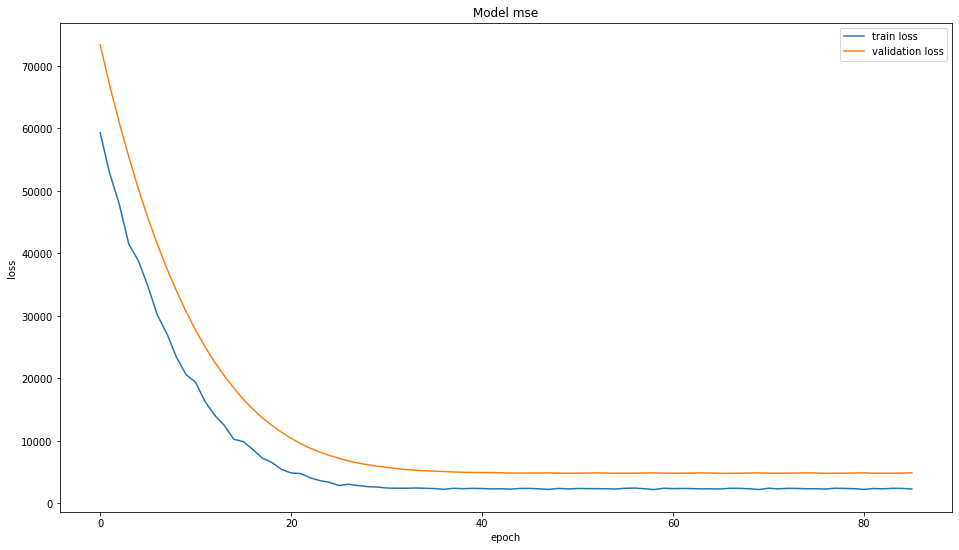

In [ ]:
plt.figure(figsize=(16,9))
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model mse')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'validation loss'])
plt.show()

### plt

In [ ]:
def plot_input(test_data, model, n_steps, n_features):
    # demonstrate prediction
    data_size=len(test_data)
    
    predict_list=[]

    for i in range(data_size-n_steps):
        x_input = array(test_data[i:i+n_steps])
        x_input = x_input.reshape((1, n_steps, n_features))
        yhat = model.predict(x_input, verbose=0)
        predict_list.append([i+n_steps, yhat[0][0]])

    plt.figure(figsize=(30,10))
    plt.plot(list(test_data))
    plt.plot(pd.DataFrame(predict_list)[0], pd.DataFrame(predict_list)[1])
    #plt.plot(30, yhat, marker="H")
    plt.show()
    
    print("MSE: "+str(mean_squared_error(test_data[n_steps:], pd.DataFrame(predict_list)[1])))

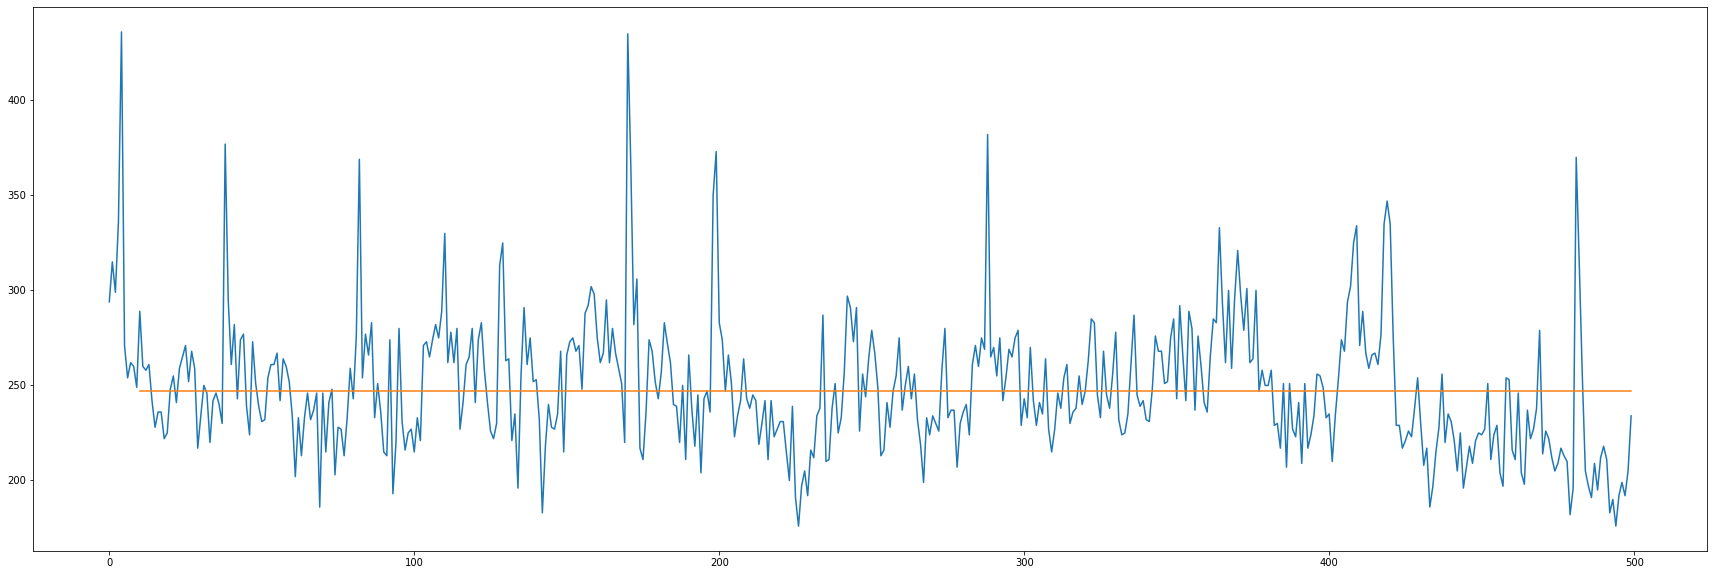

MSE: 1117.261180154888


In [ ]:
test_data=list(log_df_index['ip'])[60500:61000]
predict_list=plot_input(test_data, model, n_steps, n_features)


- 오버피팅이 생겨서 원핫으로 바꾼 값으로 다시 학습시켜봄

### split to one hot

In [ ]:
def split_onehot(dataset, target, start, end, window, horizon):
  X = []
  y = []
  start = start + window
  if end is None:
    end = len(dataset) - horizon
  for i in range(start, end):
    indices = range(i-window, i)
    X.append(dataset[indices])
    indicey = range(i+1, i+1+horizon)
    y.append(target[indicey])
  return np.array(X), np.array(y) 

In [ ]:
def process_onehot(data, cols, time_sample, n_steps, n_features, epochs, size, verbose,batch_size = 128, buffer_size = 150):
    mse_df=pd.DataFrame(columns=list(cols), index=list(time_sample))
    target=data[['pods']]
    data.drop(['pods'], axis=1, inplace=True)
    for t in time_sample:
        for i in range(3):
            if i==0:
                df=pd.DataFrame(data.resample(t).first())
            elif i==1:
                df=pd.DataFrame(data.resample(t).last())  
            elif i==2:
                df=pd.DataFrame(data.resample(t).median())

            #X, y=shape_seq(array(list(df['pods'])[:size]), n_steps, n_features)
            X, y=split_onehot(array(df), array(target), 0, size, n_steps, n_features)
            
            train_data = tf.data.Dataset.from_tensor_slices((X, y))
            train_data = train_data.cache().shuffle(buffer_size).batch(batch_size).repeat()
            
            #X_val, y_val=shape_seq(array(list(df['pods'])[size:10000]), n_steps, n_features)
            X_val, y_val=split_onehot(array(df), array(target), size, 1100, n_steps, n_features)
            
            val_data = tf.data.Dataset.from_tensor_slices((X_val, y_val))
            val_data = val_data.batch(batch_size).repeat()  
                     
            #model=set_model(train_data, n_steps, n_features, epochs, verbose, val_data)

            with tf.device('/device:GPU:0'):
                  model = tf.keras.models.Sequential([
                      Bidirectional(LSTM(200, return_sequences=True), input_shape=X.shape[-2:]),
                      Dense(256, activation='tanh'),
                      Bidirectional(tf.keras.layers.LSTM(200)),
                      tf.keras.layers.Dropout(0.4),
                      Dense(256, activation='tanh'),
                      Dense(256, activation='tanh'),
                      tf.keras.layers.Dropout(0.4),
                      Dense(256, activation='tanh'),
                      Dense(256, activation='tanh'),
                      tf.keras.layers.Dropout(0.4),
                      tf.keras.layers.Dropout(0.4),
                      Dense(256, activation='tanh'),
                      Dense(256, activation='tanh'),
                      tf.keras.layers.Dropout(0.4),
                      Dense(256, activation='tanh'),
                      Dense(256, activation='tanh'),
                      tf.keras.layers.Dropout(0.4),
                      Dense(units=n_steps),
                  ])
                  model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.007), loss=tf.keras.metrics.mean_squared_error, metrics=[tf.keras.metrics.MeanSquaredError(name='mse')])#tf.keras.optimizers.RMSprop(learning_rate=0.007), loss=tf.keras.metrics.mean_squared_error, metrics=[tf.keras.metrics.MeanSquaredError(name='mse')]
                  model.summary() 
                
                  model_path = 'model.h5'
                  early_stopings = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=20, verbose=1, mode='min')
                  checkpoint =  tf.keras.callbacks.ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, mode='min', verbose=0)
                  callbacks=[early_stopings,checkpoint]

                  hist=model.fit(train_data, epochs=epochs,steps_per_epoch=100,callbacks=callbacks, verbose=verbose,validation_data=val_data, validation_steps=20)

                  return hist, model


In [ ]:
data=pd.concat([pd.get_dummies(log_df_index['pods'], columns=['pods']), log_df_index['pods']], axis=1) 
cols=["first"] #, "last", "median"]
time_sample=['1T'] # ['0.2T','0.5T','0.75T','1T'] #, '2T','3T','4T','5T']
n_steps=5
n_features=1
epochs=50
size=1000
verbose=1
hist, model=process_onehot(data, cols, time_sample, n_steps, n_features, epochs, size, verbose)

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_18 (Bidirecti  (None, 5, 400)           481600    
 onal)                                                           
                                                                 
 dense_43 (Dense)            (None, 5, 256)            102656    
                                                                 
 bidirectional_19 (Bidirecti  (None, 400)              731200    
 onal)                                                           
                                                                 
 dropout_22 (Dropout)        (None, 400)               0         
                                                                 
 dense_44 (Dense)            (None, 256)               102656    
                                                                 
 dense_45 (Dense)            (None, 256)              

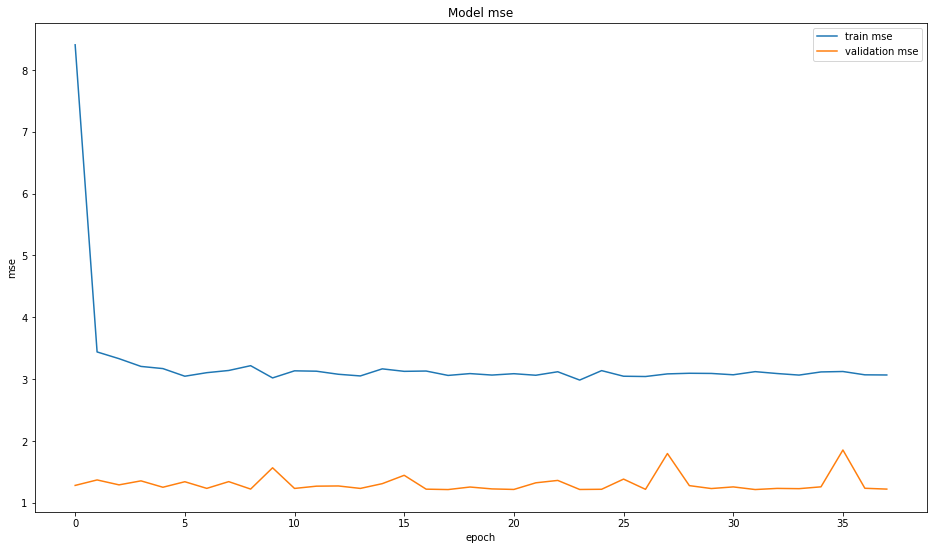

In [ ]:
plt.figure(figsize=(16,9))
plt.plot(hist.history['mse'])
plt.plot(hist.history['val_mse'])
plt.title('Model mse')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.legend(['train mse', 'validation mse'])
plt.show()

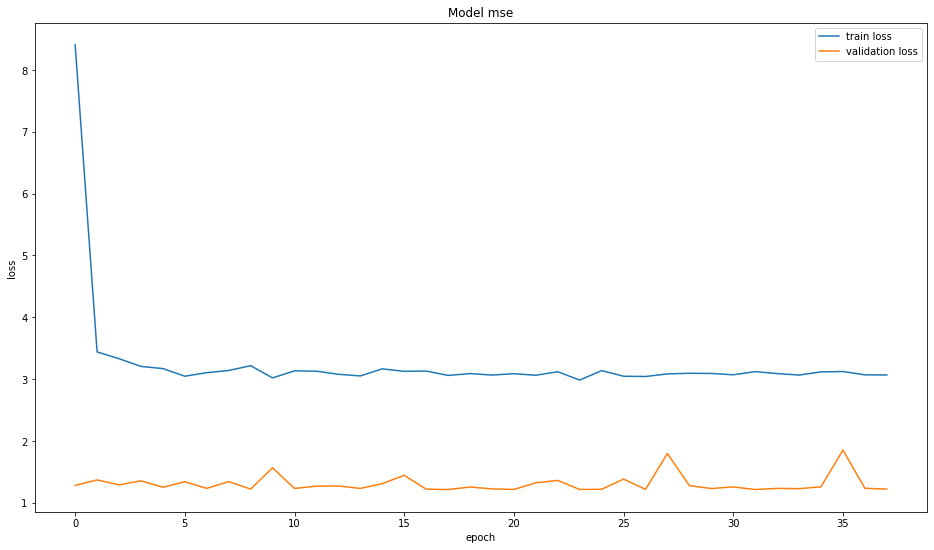

In [ ]:
plt.figure(figsize=(16,9))
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model mse')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'validation loss'])
plt.show()

In [ ]:
def split_onehot(dataset, target, start, end, window, horizon):
  X = []
  y = []
  start = start + window
  if end is None:
    end = len(dataset) - horizon
  for i in range(start, end):
    indices = range(i-window, i)
    X.append(dataset[indices])
    indicey = range(i, i+horizon)
    y.append(target[indicey])
  return np.array(X), np.array(y) 

In [ ]:
def plot_input(test_data, model, n_steps, n_features, batch_size = 128, buffer_size = 150):
    # demonstrate prediction
    data_size=len(test_data)
    
    predict_list=[]

    target=test_data[['pods']]
    test_data.drop(['pods'], axis=1, inplace=True)

    X, y = split_onehot(array(test_data), array(target), 0, None, n_steps, n_features)
    test = tf.data.Dataset.from_tensor_slices((X, y))
    test = test.cache().shuffle(buffer_size).batch(batch_size).repeat()

    for i in range(data_size-n_steps-1):
        x_input = array(X[i])
        x_input = x_input.reshape((1, n_steps, data_size))
        yhat = model.predict(x_input, verbose=0)
        predict_list.append([yhat[0][0]])

    # print(y.shape)
    # yhat = model.predict(X, verbose=0)

    # for i in range(data_size-n_steps):
    #   predict_list.append([yhat[i][0]])

    # print(pd.DataFrame(y.reshape((y.shape[-3],)), columns=['y'])['y'])

    plt.figure(figsize=(30,10))
    plt.plot(pd.DataFrame(predict_list)[0])
    plt.plot(pd.DataFrame(y.reshape((y.shape[-3],)), columns=['y'])['y'])
    #plt.plot(30, yhat, marker="H")
    plt.show()
    

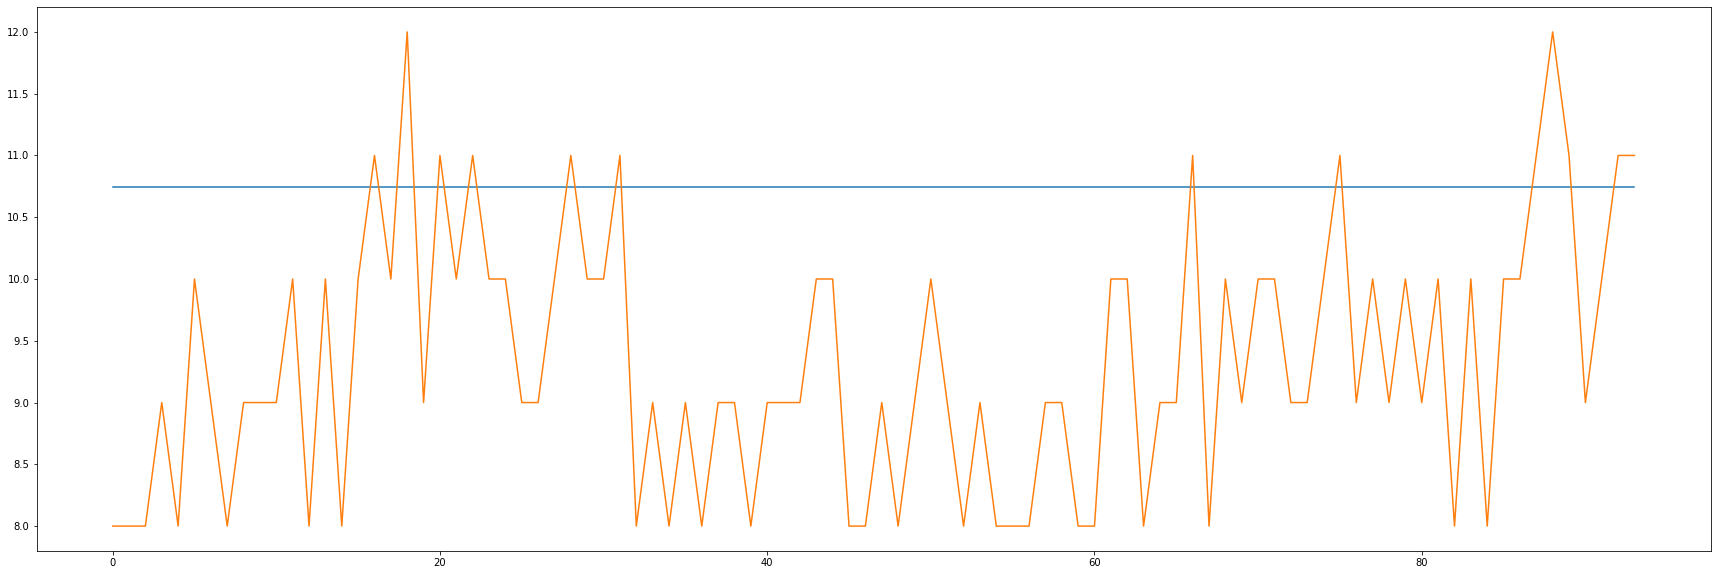

In [ ]:
test_data=pd.concat([pd.get_dummies(log_df_index['pods'], columns=['pods']), log_df_index['pods']], axis=1).iloc[1200:1300]
n_steps=5
n_features=1
epochs=50
size=1000

predict_list=plot_input(test_data, model, n_steps, n_features)